<h1><span style="color:steelblue"> Book Recommendation System </span></h1>

In [1]:
import warnings
import phik
import string
import nltk
import pickle
import os

import sqlite3
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import gensim.downloader as gdl
import hnswlib

from sklearn.preprocessing import StandardScaler
from ydata_profiling import ProfileReport
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import KeyedVectors
from surprise import Dataset, Reader, NMF, SVD, accuracy
from surprise.model_selection import train_test_split, GridSearchCV

%matplotlib inline

In [2]:
#Displaying max columns and rows:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#Suppressing FutureWarning:
warnings.simplefilter(action='ignore', category=FutureWarning)

## <span style="color:steelblue"> Data Preprocessing and EDA</span>

<em><span style="color:lightsteelblue"> Load data</span></em>

In [3]:
books = pd.read_csv('data/books_enriched.csv')
ratings = pd.read_csv('data/ratings.csv')

<div class="alert alert-block alert-info">
    
- This dataset contains six million ratings for ten thousand most popular (with most ratings) books.<br><br>
- Each book may have many editions. goodreads_book_id and best_book_id generally point to the most popular edition of a given book, while goodreads work_id refers to the book in the abstract sense.<br><br>
- Note that book_id in ratings.csv maps to work_id, not to goodreads_book_id, meaning that ratings for different editions are aggregated.

<em><span style="color:lightsteelblue"> View ratings data </span></em>

In [4]:
ratings.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [5]:
num_ratings = ratings['rating'].count()

print(f'There are {num_ratings:,} total ratings.')

There are 5,976,479 total ratings.


In [6]:
min_rating = ratings['rating'].min()
max_rating = ratings['rating'].max()

print(f'The ratings range from {min_rating} to {max_rating}.')

The ratings range from 1 to 5.


In [7]:
num_users = ratings['user_id'].nunique()

print(f'There are {num_users:,} users in total.')

There are 53,424 users in total.


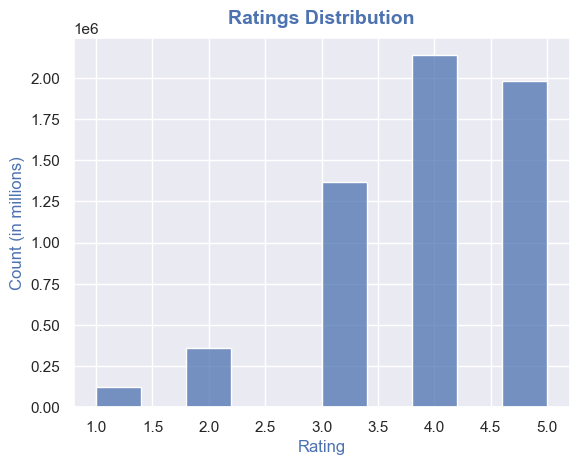

In [8]:
sns.set_theme()
sns.histplot(x=ratings['rating'], bins=10)
plt.xlabel('Rating', fontsize=12, c='#4c72b0')
plt.ylabel('Count (in millions)', fontsize=12, c='#4c72b0')
plt.title('Ratings Distribution', size=14,\
          pad=10, fontweight='bold', color='#4c72b0')

plt.show()

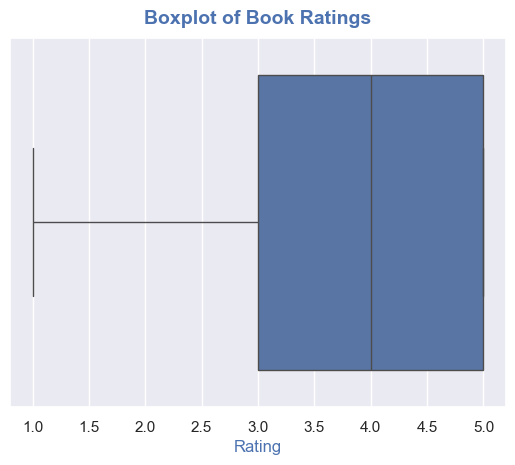

In [9]:
sns.boxplot(x=ratings['rating'], orient='h')
plt.xlabel('Rating', fontsize=12, c='#4c72b0')
plt.title('Boxplot of Book Ratings', size=14, pad=10, fontweight='bold', color='#4c72b0')

plt.show()

<em><span style="color:lightsteelblue"> View books data</span></em>

In [10]:
books.head()

,Unnamed: 0,index,authors,average_rating,best_book_id,book_id,books_count,description,genres,goodreads_book_id,image_url,isbn,isbn13,language_code,original_publication_year,original_title,pages,publishDate,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,ratings_count,small_image_url,title,work_id,work_ratings_count,work_text_reviews_count,authors_2
0,0,0,['Suzanne Collins'],4.34,2767052,1,272,WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...,"['young-adult', 'fiction', 'fantasy', 'science...",2767052,https://images.gr-assets.com/books/1447303603m...,439023483,9.780439e+12,eng,2008.0,The Hunger Games,374.0,09/14/08,66715,127936,560092,1481305,2706317,4780653,https://images.gr-assets.com/books/1447303603s...,"The Hunger Games (The Hunger Games, #1)",2792775,4942365,155254,['Suzanne Collins']
1,1,1,"['J.K. Rowling', 'Mary GrandPré']",4.44,3,2,491,Harry Potter's life is miserable. His parents ...,"['fantasy', 'fiction', 'young-adult', 'classics']",3,https://images.gr-assets.com/books/1474154022m...,439554934,9.780440e+12,eng,1997.0,Harry Potter and the Philosopher's Stone,309.0,11/01/03,75504,101676,455024,1156318,3011543,4602479,https://images.gr-assets.com/books/1474154022s...,Harry Potter and the Sorcerer's Stone (Harry P...,4640799,4800065,75867,"['J.K. Rowling', 'Mary GrandPré']"
2,2,2,['Stephenie Meyer'],3.57,41865,3,226,About three things I was absolutely positive.\...,"['young-adult', 'fantasy', 'romance', 'fiction...",41865,https://images.gr-assets.com/books/1361039443m...,316015849,9.780316e+12,eng,2005.0,Twilight,501.0,09/06/06,456191,436802,793319,875073,1355439,3866839,https://images.gr-assets.com/books/1361039443s...,"Twilight (Twilight, #1)",3212258,3916824,95009,['Stephenie Meyer']
3,3,3,['Harper Lee'],4.25,2657,4,487,The unforgettable novel of a childhood in a sl...,"['classics', 'fiction', 'historical-fiction', ...",2657,https://images.gr-assets.com/books/1361975680m...,61120081,9.780061e+12,eng,1960.0,To Kill a Mockingbird,324.0,05/23/06,60427,117415,446835,1001952,1714267,3198671,https://images.gr-assets.com/books/1361975680s...,To Kill a Mockingbird,3275794,3340896,72586,['Harper Lee']
4,4,4,['F. Scott Fitzgerald'],3.89,4671,5,1356,Alternate Cover Edition ISBN: 0743273567 (ISBN...,"['classics', 'fiction', 'historical-fiction', ...",4671,https://images.gr-assets.com/books/1490528560m...,743273567,9.780743e+12,eng,1925.0,The Great Gatsby,200.0,09/28/04,86236,197621,606158,936012,947718,2683664,https://images.gr-assets.com/books/1490528560s...,The Great Gatsby,245494,2773745,51992,['F. Scott Fitzgerald']


In [11]:
top_rated = books[books['average_rating'] >= 4.5]
top_rated_count = top_rated['work_id'].count()
print(f'There are {top_rated_count} books with an average rating of 4.5 or greater.')

There are 144 books with an average rating of 4.5 or greater.


In [12]:
mid_rated = books[(books['average_rating'] > 2.5) & (books['average_rating'] < 4.5)]
mid_rated_count = mid_rated['work_id'].count()
print(f'There are {mid_rated_count:,} books with an average rating greater than 2.5 but less than 4.5.')

There are 9,855 books with an average rating greater than 2.5 but less than 4.5.


In [13]:
low_rated = books[books['average_rating'] <= 2.5]
low_rated_count = low_rated['work_id'].count()
print(f'There is {low_rated_count} book with an average rating of 2.5 or less.')

There is 1 book with an average rating of 2.5 or less.


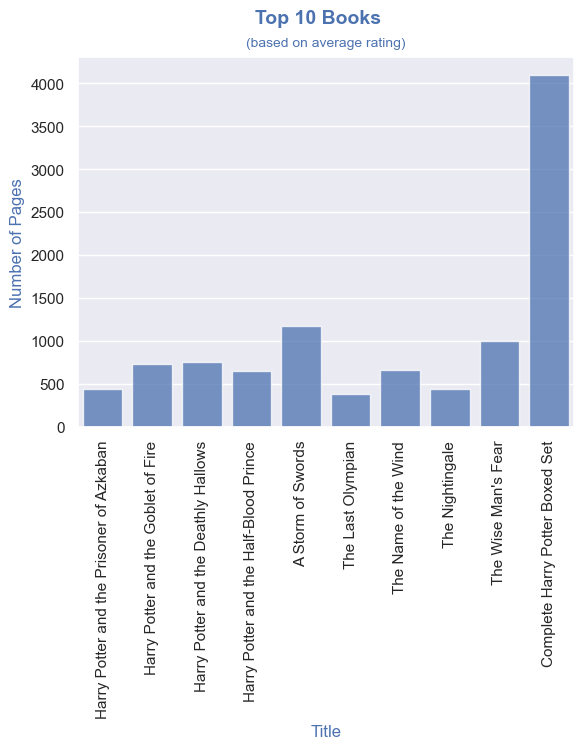

In [14]:
top_10_books = top_rated[:10]

sns.barplot(data=top_10_books,
            x='original_title', y='pages', alpha=.75, saturation=100)
plt.xlabel('Title', fontsize=12, c='#4c72b0')
plt.xticks(rotation=90)
plt.ylabel('Number of Pages', fontsize=12, c='#4c72b0')
plt.suptitle('Top 10 Books', size=14, fontweight='bold', color='#4c72b0')
plt.title('(based on average rating)', size=10, pad=8, c='#4c72b0')

plt.show()

<em><span style="color:lightsteelblue"> Compare books in ratings df to books in books df  </span></em>

In [15]:
# 'book_id' in ratings df correspond to 'work_id' in books df.

ratings.rename(columns={'book_id':'work_id'}, inplace=True)

In [16]:
print(ratings['work_id'].nunique())
print(books['work_id'].nunique())

10000
10000


In [17]:
matched_ids = ratings[ratings['work_id'].isin(books['work_id'])]
matched_ids_count = matched_ids['work_id'].nunique()

print(f'There are {matched_ids_count} books in the books df that have been rated.')

There are 176 books in the books df that have been rated.


In [18]:
unmatched_ids = ratings[~ratings['work_id'].isin(books['work_id'])]
unmatched_ids_count = unmatched_ids['work_id'].nunique()

print(f'There are {unmatched_ids_count} books from the books df that have not been rated.')
print(f'There are {unmatched_ids_count} books that have been rated but do not exist in the books df.')

There are 9824 books from the books df that have not been rated.
There are 9824 books that have been rated but do not exist in the books df.


<em><span style="color:lightsteelblue"> Remove books that don't exist in books df from ratings df  </span></em>

In [19]:
ratings['work_id'] = matched_ids['work_id']

In [20]:
ratings.head()

,user_id,work_id,rating
0,1,NaN,5
1,2,NaN,4
2,2,NaN,5
3,2,NaN,5
4,2,NaN,3


In [21]:
ratings.dropna(inplace=True)

In [22]:
ratings['work_id'] = ratings['work_id'].astype('int64')

In [23]:
ratings.head()

,user_id,work_id,rating
60,8,362,5
84,4,87,5
169,11,574,3
181,11,115,4
209,15,87,5


In [24]:
print(ratings['work_id'].dtype)
print(books['work_id'].dtype)

int64
int64


In [25]:
print(ratings['work_id'].nunique())
print(books['work_id'].nunique())

176
10000


<div class="alert alert-block alert-info">
    
- The ratings df suggest that only 176 books from the books df have been rated. The other 9,824 rated books found in the ratings df do not exist in the books df. 
<br><br>
- The average rating in the books df indicates that all 10,000 books in the books df have been rated.
<br><br>
- average_rating in the books df may not reflect the same ratings as the ratings df.

<em><span style="color:lightsteelblue"> Merge books df with ratings df </span></em>

In [26]:
goodbooks = books.merge(ratings, how='left', on='work_id')

In [27]:
goodbooks.head()

,Unnamed: 0,index,authors,average_rating,best_book_id,book_id,books_count,description,genres,goodreads_book_id,image_url,isbn,isbn13,language_code,original_publication_year,original_title,pages,publishDate,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,ratings_count,small_image_url,title,work_id,work_ratings_count,work_text_reviews_count,authors_2,user_id,rating
0,0,0,['Suzanne Collins'],4.34,2767052,1,272,WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...,"['young-adult', 'fiction', 'fantasy', 'science...",2767052,https://images.gr-assets.com/books/1447303603m...,439023483,9.780439e+12,eng,2008.0,The Hunger Games,374.0,09/14/08,66715,127936,560092,1481305,2706317,4780653,https://images.gr-assets.com/books/1447303603s...,"The Hunger Games (The Hunger Games, #1)",2792775,4942365,155254,['Suzanne Collins'],NaN,NaN
1,1,1,"['J.K. Rowling', 'Mary GrandPré']",4.44,3,2,491,Harry Potter's life is miserable. His parents ...,"['fantasy', 'fiction', 'young-adult', 'classics']",3,https://images.gr-assets.com/books/1474154022m...,439554934,9.780440e+12,eng,1997.0,Harry Potter and the Philosopher's Stone,309.0,11/01/03,75504,101676,455024,1156318,3011543,4602479,https://images.gr-assets.com/books/1474154022s...,Harry Potter and the Sorcerer's Stone (Harry P...,4640799,4800065,75867,"['J.K. Rowling', 'Mary GrandPré']",NaN,NaN
2,2,2,['Stephenie Meyer'],3.57,41865,3,226,About three things I was absolutely positive.\...,"['young-adult', 'fantasy', 'romance', 'fiction...",41865,https://images.gr-assets.com/books/1361039443m...,316015849,9.780316e+12,eng,2005.0,Twilight,501.0,09/06/06,456191,436802,793319,875073,1355439,3866839,https://images.gr-assets.com/books/1361039443s...,"Twilight (Twilight, #1)",3212258,3916824,95009,['Stephenie Meyer'],NaN,NaN
3,3,3,['Harper Lee'],4.25,2657,4,487,The unforgettable novel of a childhood in a sl...,"['classics', 'fiction', 'historical-fiction', ...",2657,https://images.gr-assets.com/books/1361975680m...,61120081,9.780061e+12,eng,1960.0,To Kill a Mockingbird,324.0,05/23/06,60427,117415,446835,1001952,1714267,3198671,https://images.gr-assets.com/books/1361975680s...,To Kill a Mockingbird,3275794,3340896,72586,['Harper Lee'],NaN,NaN
4,4,4,['F. Scott Fitzgerald'],3.89,4671,5,1356,Alternate Cover Edition ISBN: 0743273567 (ISBN...,"['classics', 'fiction', 'historical-fiction', ...",4671,https://images.gr-assets.com/books/1490528560m...,743273567,9.780743e+12,eng,1925.0,The Great Gatsby,200.0,09/28/04,86236,197621,606158,936012,947718,2683664,https://images.gr-assets.com/books/1490528560s...,The Great Gatsby,245494,2773745,51992,['F. Scott Fitzgerald'],NaN,NaN


<em><span style="color:lightsteelblue">Clean [user_id] and [rating]</span></em>

In [28]:
goodbooks['user_id'].fillna(0, inplace=True)
goodbooks['rating'].fillna(0, inplace=True)

In [29]:
goodbooks.head()

,Unnamed: 0,index,authors,average_rating,best_book_id,book_id,books_count,description,genres,goodreads_book_id,image_url,isbn,isbn13,language_code,original_publication_year,original_title,pages,publishDate,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,ratings_count,small_image_url,title,work_id,work_ratings_count,work_text_reviews_count,authors_2,user_id,rating
0,0,0,['Suzanne Collins'],4.34,2767052,1,272,WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...,"['young-adult', 'fiction', 'fantasy', 'science...",2767052,https://images.gr-assets.com/books/1447303603m...,439023483,9.780439e+12,eng,2008.0,The Hunger Games,374.0,09/14/08,66715,127936,560092,1481305,2706317,4780653,https://images.gr-assets.com/books/1447303603s...,"The Hunger Games (The Hunger Games, #1)",2792775,4942365,155254,['Suzanne Collins'],0.0,0.0
1,1,1,"['J.K. Rowling', 'Mary GrandPré']",4.44,3,2,491,Harry Potter's life is miserable. His parents ...,"['fantasy', 'fiction', 'young-adult', 'classics']",3,https://images.gr-assets.com/books/1474154022m...,439554934,9.780440e+12,eng,1997.0,Harry Potter and the Philosopher's Stone,309.0,11/01/03,75504,101676,455024,1156318,3011543,4602479,https://images.gr-assets.com/books/1474154022s...,Harry Potter and the Sorcerer's Stone (Harry P...,4640799,4800065,75867,"['J.K. Rowling', 'Mary GrandPré']",0.0,0.0
2,2,2,['Stephenie Meyer'],3.57,41865,3,226,About three things I was absolutely positive.\...,"['young-adult', 'fantasy', 'romance', 'fiction...",41865,https://images.gr-assets.com/books/1361039443m...,316015849,9.780316e+12,eng,2005.0,Twilight,501.0,09/06/06,456191,436802,793319,875073,1355439,3866839,https://images.gr-assets.com/books/1361039443s...,"Twilight (Twilight, #1)",3212258,3916824,95009,['Stephenie Meyer'],0.0,0.0
3,3,3,['Harper Lee'],4.25,2657,4,487,The unforgettable novel of a childhood in a sl...,"['classics', 'fiction', 'historical-fiction', ...",2657,https://images.gr-assets.com/books/1361975680m...,61120081,9.780061e+12,eng,1960.0,To Kill a Mockingbird,324.0,05/23/06,60427,117415,446835,1001952,1714267,3198671,https://images.gr-assets.com/books/1361975680s...,To Kill a Mockingbird,3275794,3340896,72586,['Harper Lee'],0.0,0.0
4,4,4,['F. Scott Fitzgerald'],3.89,4671,5,1356,Alternate Cover Edition ISBN: 0743273567 (ISBN...,"['classics', 'fiction', 'historical-fiction', ...",4671,https://images.gr-assets.com/books/1490528560m...,743273567,9.780743e+12,eng,1925.0,The Great Gatsby,200.0,09/28/04,86236,197621,606158,936012,947718,2683664,https://images.gr-assets.com/books/1490528560s...,The Great Gatsby,245494,2773745,51992,['F. Scott Fitzgerald'],0.0,0.0


In [30]:
goodbooks['user_id'] = goodbooks['user_id'].astype('int64')
goodbooks['rating'] = goodbooks['rating'].astype('int64')

In [31]:
print(goodbooks['user_id'].dtypes)
print(goodbooks['rating'].dtypes)

int64
int64


In [32]:
goodbooks.sample(5)

,Unnamed: 0,index,authors,average_rating,best_book_id,book_id,books_count,description,genres,goodreads_book_id,image_url,isbn,isbn13,language_code,original_publication_year,original_title,pages,publishDate,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,ratings_count,small_image_url,title,work_id,work_ratings_count,work_text_reviews_count,authors_2,user_id,rating
77294,4807,4807,"['Milan Kundera', 'Suzanne Rappaport']",3.86,26101,5374,113,Laughable Loves is a collection of stories tha...,"['fiction', 'classics', 'contemporary', 'philo...",26101,https://s.gr-assets.com/assets/nophoto/book/11...,571206921,9.780571e+12,eng,1970.0,Směšné lásky,287.0,August 21st 2000,179,838,4631,7271,4489,12984,https://s.gr-assets.com/assets/nophoto/book/50...,Laughable Loves,3838,17408,781,"['Milan Kundera', 'Suzanne Rappaport']",23403,5
71921,4493,4493,['Jonathan Maberry'],3.98,3993839,4995,30,When you have to kill the same terrorist twice...,"['horror', 'thriller', 'fiction', 'science-fic...",3993839,https://s.gr-assets.com/assets/nophoto/book/11...,312382855,9.780312e+12,eng,2009.0,Patient Zero,421.0,March 3rd 2009,508,1148,4274,7523,7749,19852,https://s.gr-assets.com/assets/nophoto/book/50...,"Patient Zero (Joe Ledger, #1)",4039913,21202,1735,['Jonathan Maberry'],0,0
4496,292,292,['Wilson Rawls'],4.04,10365,321,69,"A loving threesome, they ranged the dark hills...","['classics', 'fiction', 'young-adult', 'histor...",10365,https://images.gr-assets.com/books/1166154337m...,375806814,9.780376e+12,eng,1961.0,Where the Red Fern Grows,272.0,05/09/00,6585,15232,53560,89699,115103,268548,https://images.gr-assets.com/books/1166154337s...,Where the Red Fern Grows,115,280179,8725,['Wilson Rawls'],10602,4
119733,7970,7970,['Margaret Edson'],4.20,171201,9707,11,"Winner of the Pulitzer Prize, the New York Dra...","['fiction', 'contemporary', 'classics']",171201,https://images.gr-assets.com/books/1327908183m...,571198775,9.780571e+12,eng,1995.0,Wit : A Play,85.0,March 29th 1999,167,383,1659,3563,5129,10601,https://images.gr-assets.com/books/1327908183s...,Wit,2206,10901,417,['Margaret Edson'],38027,3
90826,5414,5414,['Cornelius Ryan'],4.31,161156,6131,73,The unparalleled work of history that recreate...,"['history', 'nonfiction', 'classics']",161156,https://s.gr-assets.com/assets/nophoto/book/11...,671890913,9.780672e+12,eng,1959.0,The Longest Day,350.0,May 1st 1994,114,271,1931,5826,7694,14949,https://s.gr-assets.com/assets/nophoto/book/50...,The Longest Day,1413765,15836,416,['Cornelius Ryan'],0,0


<em><span style="color:lightsteelblue">Check shape of data</span></em>

In [33]:
goodbooks.shape

(140010, 32)

<em><span style="color:lightsteelblue">View missing values</span></em>

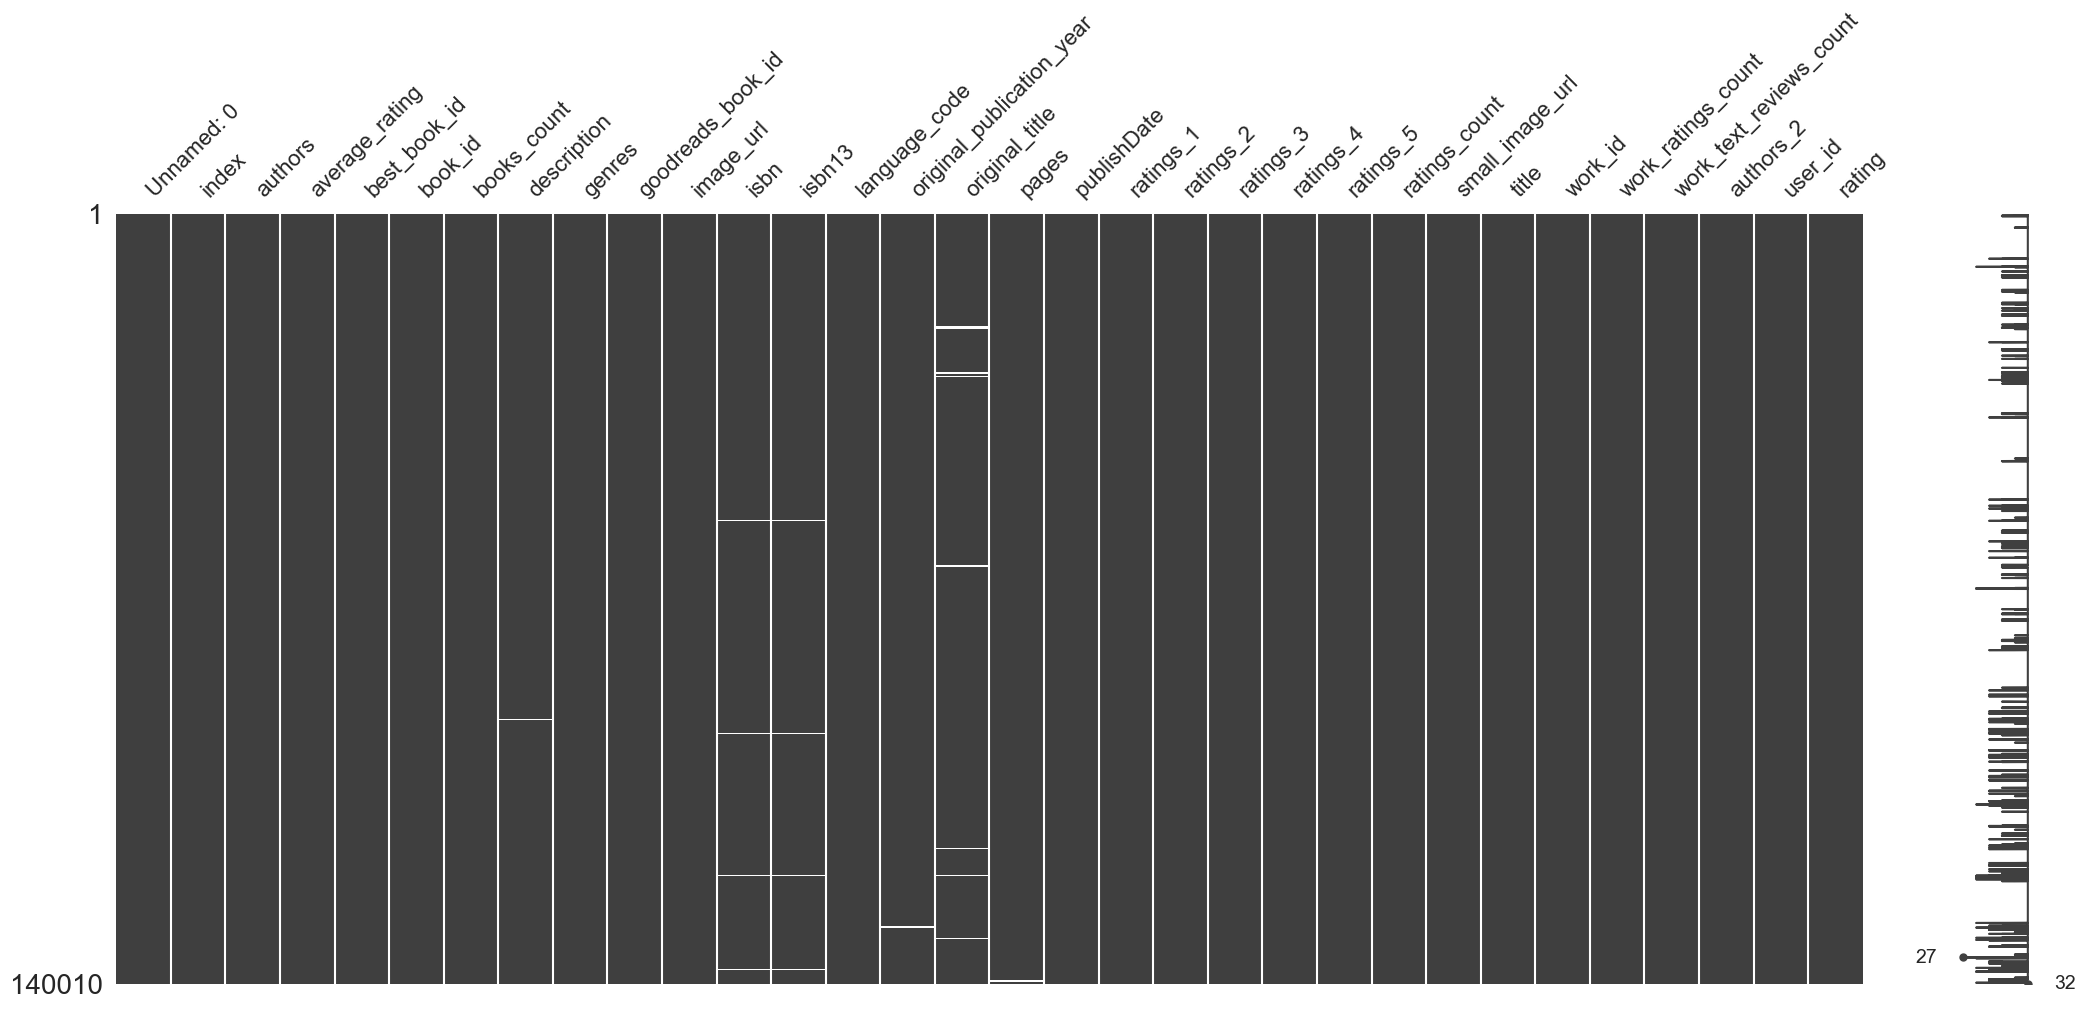

In [34]:
msno.matrix(goodbooks)
plt.show()

<em><span style="color:lightsteelblue">Confirm duplicate column</span></em>

In [35]:
author_df = goodbooks[['authors', 'authors_2']]
author_df.sample(5)

,authors,authors_2
132850,['[David Auburn]'],['[David Auburn]']
31808,['Patricia Schultz'],['Patricia Schultz']
28439,['Charles Bukowski'],['Charles Bukowski']
76898,['Greg Bear'],['Greg Bear']
125653,['[Plum Sykes]'],['[Plum Sykes]']


In [36]:
unmatched_authors = author_df[~author_df['authors'].isin(author_df['authors_2'])]
unmatched_authors['authors'].nunique()

0

<em><span style="color:lightsteelblue">Drop redundant columns and columns containing missing values</span></em>

In [37]:
goodbooks.drop(columns=['Unnamed: 0', 'index', 'average_rating', 
                        'best_book_id', 'isbn', 'isbn13',
                        'original_publication_year', 'original_title',
                        'pages','publishDate', 'authors_2'], inplace=True)

<em><span style="color:lightsteelblue">Recheck shape</span></em>

In [38]:
goodbooks.shape

(140010, 21)

<em><span style="color:lightsteelblue">Handle missing values in [description]</span></em>

In [39]:
goodbooks['description'].isna().sum()

209

In [40]:
goodbooks.dropna(subset=['description'], inplace=True)

In [41]:
goodbooks['description'].isna().sum()

0

<em><span style="color:lightsteelblue">Recheck shape</span></em>

In [42]:
goodbooks.shape

(139801, 21)

<em><span style="color:lightsteelblue">Generate profile report (add. EDA) </span></em>

In [43]:
goodbooks_report = ProfileReport(goodbooks.sample(10000, random_state=42),
                                vars={'num':{'low_categorical_threshold':0}},
                                correlations={'auto': {'calculate':False}})
# goodbooks_report.to_file('goodbooks_report.html')

<em><span style="color:lightsteelblue">Drop imbalanced column</span></em>

In [44]:
goodbooks.drop(columns=['language_code'], inplace=True)

In [45]:
goodbooks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139801 entries, 0 to 140009
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   authors                  139801 non-null  object
 1   book_id                  139801 non-null  int64 
 2   books_count              139801 non-null  int64 
 3   description              139801 non-null  object
 4   genres                   139801 non-null  object
 5   goodreads_book_id        139801 non-null  int64 
 6   image_url                139801 non-null  object
 7   ratings_1                139801 non-null  int64 
 8   ratings_2                139801 non-null  int64 
 9   ratings_3                139801 non-null  int64 
 10  ratings_4                139801 non-null  int64 
 11  ratings_5                139801 non-null  int64 
 12  ratings_count            139801 non-null  int64 
 13  small_image_url          139801 non-null  object
 14  title               

<em><span style="color:lightsteelblue">Select features using phik correlations and p-values</span></em>

In [46]:
goodbooks_phik = goodbooks.copy()
interval_columns = ['book_id', 'books_count', 'goodreads_book_id',
                    'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4',
                    'ratings_5', 'ratings_count','work_id', 'work_ratings_count',
                    'work_text_reviews_count','user_id']

for c in goodbooks_phik.columns:
    if c not in interval_columns:
        goodbooks_phik[c] = goodbooks_phik[c].astype('category')

In [47]:
phik_correlations = []
phik_significances = []
columns = goodbooks_phik.columns
y = goodbooks_phik['rating']

for c in columns:
    x = goodbooks_phik[c]
    if c in interval_columns:
        phik_correlations.append(phik.phik_from_array(x,y,[c]))
        phik_significances.append(phik.significance.significance_from_array(x,y,[c])[0])
    else:
        phik_correlations.append(phik.phik_from_array(x,y))
        phik_significances.append(phik.significance.significance_from_array(x,y)[0])

C:\Users\xanaa\anaconda3\Lib\site-packages\phik\data_quality.py:119: UserWarning: The number of unique values of variable x is large: 5028. Are you sure this is not an interval variable? Analysis might be slow.
  warnings.warn(
C:\Users\xanaa\anaconda3\Lib\site-packages\phik\data_quality.py:119: UserWarning: The number of unique values of variable x is large: 5028. Are you sure this is not an interval variable? Analysis might be slow.
  warnings.warn(
C:\Users\xanaa\anaconda3\Lib\site-packages\phik\data_quality.py:119: UserWarning: The number of unique values of variable x is large: 9772. Are you sure this is not an interval variable? Analysis might be slow.
  warnings.warn(
C:\Users\xanaa\anaconda3\Lib\site-packages\phik\data_quality.py:119: UserWarning: The number of unique values of variable x is large: 9772. Are you sure this is not an interval variable? Analysis might be slow.
  warnings.warn(
C:\Users\xanaa\anaconda3\Lib\site-packages\phik\data_quality.py:119: UserWarning: The nu

In [48]:
phik_df = pd.DataFrame({'phik': phik_correlations, 'p-value': phik_significances},
                      index=columns)
phik_df.sort_values(by='phik', ascending=False, inplace=True)

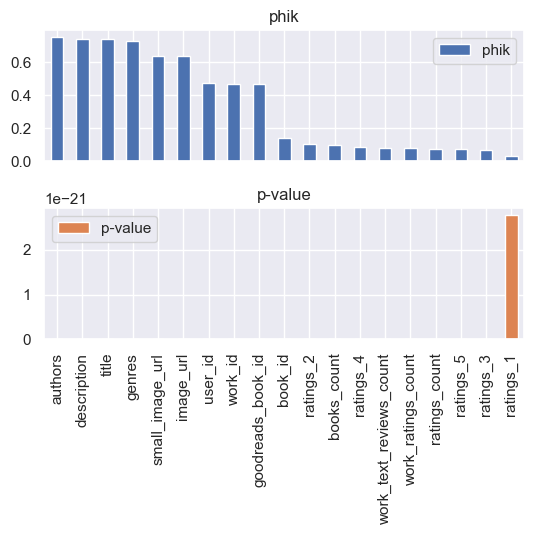

In [49]:
phik_df.iloc[1:].plot.bar(subplots=True, figsize=(5.5,5.5))
plt.tight_layout()
plt.show()

In [50]:
goodbooks.drop(columns=['book_id', 'ratings_2', 'books_count', 'ratings_4',
                        'work_text_reviews_count', 'work_ratings_count', 
                        'ratings_count', 'ratings_5', 'ratings_3',
                        'ratings_1'], inplace=True)

<em><span style="color:lightsteelblue">Recheck shape</span></em>

In [51]:
goodbooks.shape

(139801, 10)

In [52]:
goodbooks.head(3)

,authors,description,genres,goodreads_book_id,image_url,small_image_url,title,work_id,user_id,rating
0,['Suzanne Collins'],WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...,"['young-adult', 'fiction', 'fantasy', 'science...",2767052,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...,"The Hunger Games (The Hunger Games, #1)",2792775,0,0
1,"['J.K. Rowling', 'Mary GrandPré']",Harry Potter's life is miserable. His parents ...,"['fantasy', 'fiction', 'young-adult', 'classics']",3,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...,Harry Potter and the Sorcerer's Stone (Harry P...,4640799,0,0
2,['Stephenie Meyer'],About three things I was absolutely positive.\...,"['young-adult', 'fantasy', 'romance', 'fiction...",41865,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...,"Twilight (Twilight, #1)",3212258,0,0


<em><span style="color:lightsteelblue">Clean [authors] and [title]</span></em>

In [53]:
goodbooks['title'] = goodbooks['title'].str.replace(r'\s*\(.*?\)\s*', ' ', regex=True)
goodbooks['title'] = goodbooks['title'].str.strip()

In [54]:
goodbooks['authors'] = goodbooks['authors'].str.replace(r"[\[\]'']", '', regex=True).str.strip()
goodbooks['authors'] = goodbooks['authors'].apply((lambda x: x.split(',')[0].split(';')[0].strip()))

In [55]:
goodbooks.head(3)

,authors,description,genres,goodreads_book_id,image_url,small_image_url,title,work_id,user_id,rating
0,Suzanne Collins,WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...,"['young-adult', 'fiction', 'fantasy', 'science...",2767052,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...,The Hunger Games,2792775,0,0
1,J.K. Rowling,Harry Potter's life is miserable. His parents ...,"['fantasy', 'fiction', 'young-adult', 'classics']",3,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...,Harry Potter and the Sorcerer's Stone,4640799,0,0
2,Stephenie Meyer,About three things I was absolutely positive.\...,"['young-adult', 'fantasy', 'romance', 'fiction...",41865,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...,Twilight,3212258,0,0


<em><span style="color:lightsteelblue">(add. EDA)</span></em>

In [56]:
authors = goodbooks['authors'].value_counts()
top_10_authors = authors[:10]
top_10_authors

Plum Sykes                 7564
Isabel Allende             6792
Barbara Taylor Bradford    6466
Wilson Rawls               5615
M.M. Kaye                  5467
Patricia Schultz           5408
Neil Strauss               3560
Max Brooks                 3225
Anonymous                  2507
Frank Herbert              2314
Name: authors, dtype: int64

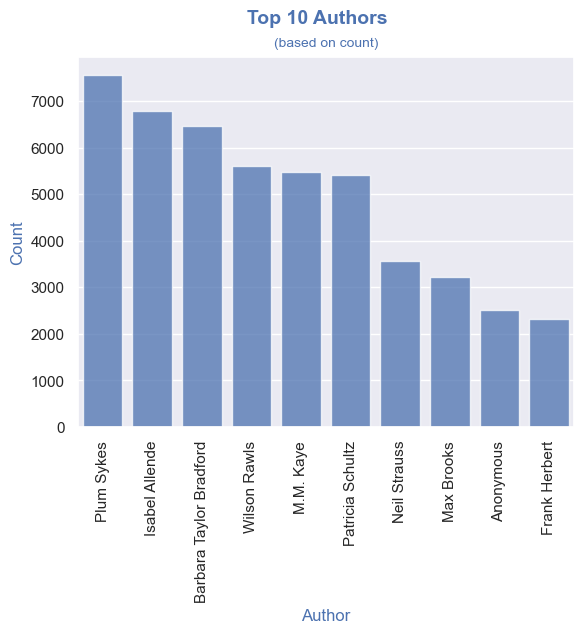

In [57]:
sns.barplot(data=top_10_authors, alpha=.75, saturation=100)
plt.xlabel('Author', fontsize=12, c='#4c72b0')
plt.xticks(rotation=90)
plt.ylabel('Count', fontsize=12, c='#4c72b0')
plt.suptitle('Top 10 Authors', size=14, fontweight='bold', color='#4c72b0')
plt.title('(based on count)', size=10, pad=8, c='#4c72b0')

plt.show()

## <span style="color:steelblue"> Feature Engineering </span>

<em><span style="color:lightsteelblue">Prep [authors] for embeddings</span></em>

In [58]:
# authors_1 = goodbooks['authors'].copy()
# authors_1[:10]

In [59]:
# translator = str.maketrans('', '', string.punctuation + string.digits)
# authors_1 = authors_1.apply(lambda x: x.translate(translator))
# authors_1[:10]

In [60]:
# authors_1 = authors_1.str.lower()
# authors_1[:10]

<em><span style="color:lightsteelblue">Prep [description] for embeddings</span></em>

In [61]:
goodbooks['description'][:10]

0    WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...
1    Harry Potter's life is miserable. His parents ...
2    About three things I was absolutely positive.\...
3    The unforgettable novel of a childhood in a sl...
4    Alternate Cover Edition ISBN: 0743273567 (ISBN...
5    Despite the tumor-shrinking medical miracle th...
6    In a hole in the ground there lived a hobbit. ...
7    The hero-narrator of The Catcher in the Rye is...
8    World-renowned Harvard symbologist Robert Lang...
9    Alternate cover edition of ISBN 9780679783268S...
Name: description, dtype: object

In [62]:
translator = str.maketrans('', '', string.punctuation + string.digits)
goodbooks['description'] = goodbooks['description'].apply(lambda x: x.translate(translator))
goodbooks['description'][:10]

0    WINNING MEANS FAME AND FORTUNELOSING MEANS CER...
1    Harry Potters life is miserable His parents ar...
2    About three things I was absolutely positive\n...
3    The unforgettable novel of a childhood in a sl...
4    Alternate Cover Edition ISBN  ISBN The Great G...
5    Despite the tumorshrinking medical miracle tha...
6    In a hole in the ground there lived a hobbit N...
7    The heronarrator of The Catcher in the Rye is ...
8    Worldrenowned Harvard symbologist Robert Langd...
9    Alternate cover edition of ISBN Since its imme...
Name: description, dtype: object

In [63]:
goodbooks['description'] = goodbooks['description'].str.lower()
goodbooks['description'][:10]

0    winning means fame and fortunelosing means cer...
1    harry potters life is miserable his parents ar...
2    about three things i was absolutely positive\n...
3    the unforgettable novel of a childhood in a sl...
4    alternate cover edition isbn  isbn the great g...
5    despite the tumorshrinking medical miracle tha...
6    in a hole in the ground there lived a hobbit n...
7    the heronarrator of the catcher in the rye is ...
8    worldrenowned harvard symbologist robert langd...
9    alternate cover edition of isbn since its imme...
Name: description, dtype: object

In [64]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\xanaa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [65]:
en_stopwords = stopwords.words('english')
en_stopwords = set(en_stopwords)

In [66]:
def filter_description(desc):
    words = desc.split() 
    filtered_words = [w for w in words if w not in en_stopwords and len(w) > 3]
    return ' '.join(filtered_words)

In [67]:
goodbooks['description'] = goodbooks['description'].apply(filter_description)
goodbooks['description'][:10]

0    winning means fame fortunelosing means certain...
1    harry potters life miserable parents dead stuc...
2    three things absolutely positive first edward ...
3    unforgettable novel childhood sleepy southern ...
4    alternate cover edition isbn isbn great gatsby...
5    despite tumorshrinking medical miracle bought ...
6    hole ground lived hobbit nasty dirty hole fill...
7    heronarrator catcher ancient child sixteen nat...
8    worldrenowned harvard symbologist robert langd...
9    alternate cover edition isbn since immediate s...
Name: description, dtype: object

In [68]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\xanaa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [69]:
goodbooks['description'] = goodbooks['description'].apply(word_tokenize)
goodbooks['description'][:10]

0    [winning, means, fame, fortunelosing, means, c...
1    [harry, potters, life, miserable, parents, dea...
2    [three, things, absolutely, positive, first, e...
3    [unforgettable, novel, childhood, sleepy, sout...
4    [alternate, cover, edition, isbn, isbn, great,...
5    [despite, tumorshrinking, medical, miracle, bo...
6    [hole, ground, lived, hobbit, nasty, dirty, ho...
7    [heronarrator, catcher, ancient, child, sixtee...
8    [worldrenowned, harvard, symbologist, robert, ...
9    [alternate, cover, edition, isbn, since, immed...
Name: description, dtype: object

<em><span style="color:lightsteelblue">Inspect [genres]</span></em>

In [70]:
# goodbooks['genres'][:10]

<em><span style="color:lightsteelblue">Load transfer learning model</span></em>

In [71]:
w2v_path = gdl.load("word2vec-google-news-300", return_path=True)

In [72]:
w2v_model = KeyedVectors.load_word2vec_format(w2v_path, binary=True)

<em><span style="color:lightsteelblue">Create embeddings (Content-based filtering)</span></em>

In [73]:
def get_average_embedding(text, model):
    if not text:
        return np.zeros(model.vector_size)
    vectors = [model[t] for t in text if t in model]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

In [74]:
# goodbooks['auth_embeddings'] = authors_1.apply(lambda x: get_average_embedding(x, w2v_model))

In [75]:
goodbooks['embeddings'] = goodbooks['description'].apply(lambda x: get_average_embedding(x, w2v_model))

In [76]:
# goodbooks['genr_embeddings'] = goodbooks['genres'].apply(lambda x: get_average_embedding(x, w2v_model))

In [77]:
goodbooks.head()

,authors,description,genres,goodreads_book_id,image_url,small_image_url,title,work_id,user_id,rating,embeddings
0,Suzanne Collins,"[winning, means, fame, fortunelosing, means, c...","['young-adult', 'fiction', 'fantasy', 'science...",2767052,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...,The Hunger Games,2792775,0,0,"[0.034551818, 0.07394084, 0.0451905, 0.0879799..."
1,J.K. Rowling,"[harry, potters, life, miserable, parents, dea...","['fantasy', 'fiction', 'young-adult', 'classics']",3,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...,Harry Potter and the Sorcerer's Stone,4640799,0,0,"[0.0453708, 0.046102505, 0.0064881225, 0.03284..."
2,Stephenie Meyer,"[three, things, absolutely, positive, first, e...","['young-adult', 'fantasy', 'romance', 'fiction...",41865,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...,Twilight,3212258,0,0,"[0.057015877, -0.0043905755, 0.04261045, 0.076..."
3,Harper Lee,"[unforgettable, novel, childhood, sleepy, sout...","['classics', 'fiction', 'historical-fiction', ...",2657,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...,To Kill a Mockingbird,3275794,0,0,"[0.08347933, 0.011099372, 0.008116279, 0.07396..."
4,F. Scott Fitzgerald,"[alternate, cover, edition, isbn, isbn, great,...","['classics', 'fiction', 'historical-fiction', ...",4671,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...,The Great Gatsby,245494,0,0,"[0.009168668, 0.052608237, -0.045570202, 0.136..."


In [78]:
goodbooks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139801 entries, 0 to 140009
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   authors            139801 non-null  object
 1   description        139801 non-null  object
 2   genres             139801 non-null  object
 3   goodreads_book_id  139801 non-null  int64 
 4   image_url          139801 non-null  object
 5   small_image_url    139801 non-null  object
 6   title              139801 non-null  object
 7   work_id            139801 non-null  int64 
 8   user_id            139801 non-null  int64 
 9   rating             139801 non-null  int64 
 10  embeddings         139801 non-null  object
dtypes: int64(4), object(7)
memory usage: 12.8+ MB


<em><span style="color:lightsteelblue">Combine embeddings</span></em>

In [79]:
# def combine_embeddings(row):
#      return row['auth_embeddings'] + row['desc_embeddings'] + row['genr_embeddings']

In [80]:
# goodbooks['comb_embeddings'] = goodbooks.apply(combine_embeddings, axis=1)

In [81]:
# goodbooks.head()

<em><span style="color:lightsteelblue">Flatten Embeddings</span></em>

In [82]:
flat_embeddings = pd.DataFrame(goodbooks['embeddings'].tolist())

<em><span style="color:lightsteelblue">Standardize Embeddings</span></em>

In [83]:
scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(flat_embeddings)

In [84]:
goodbooks['scaled_embeddings'] = list(scaled_embeddings)

In [85]:
goodbooks.head()

,authors,description,genres,goodreads_book_id,image_url,small_image_url,title,work_id,user_id,rating,embeddings,scaled_embeddings
0,Suzanne Collins,"[winning, means, fame, fortunelosing, means, c...","['young-adult', 'fiction', 'fantasy', 'science...",2767052,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...,The Hunger Games,2792775,0,0,"[0.034551818, 0.07394084, 0.0451905, 0.0879799...","[-0.5669854075554559, 0.8408763554235134, 1.44..."
1,J.K. Rowling,"[harry, potters, life, miserable, parents, dea...","['fantasy', 'fiction', 'young-adult', 'classics']",3,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...,Harry Potter and the Sorcerer's Stone,4640799,0,0,"[0.0453708, 0.046102505, 0.0064881225, 0.03284...","[-0.22157077142775045, -0.10495800489880126, 0..."
2,Stephenie Meyer,"[three, things, absolutely, positive, first, e...","['young-adult', 'fantasy', 'romance', 'fiction...",41865,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...,Twilight,3212258,0,0,"[0.057015877, -0.0043905755, 0.04261045, 0.076...","[0.1502184704327126, -1.820509067507336, 1.351..."
3,Harper Lee,"[unforgettable, novel, childhood, sleepy, sout...","['classics', 'fiction', 'historical-fiction', ...",2657,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...,To Kill a Mockingbird,3275794,0,0,"[0.08347933, 0.011099372, 0.008116279, 0.07396...","[0.9951098888844948, -1.2942231766953876, 0.14..."
4,F. Scott Fitzgerald,"[alternate, cover, edition, isbn, isbn, great,...","['classics', 'fiction', 'historical-fiction', ...",4671,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...,The Great Gatsby,245494,0,0,"[0.009168668, 0.052608237, -0.045570202, 0.136...","[-1.3773863028223081, 0.11608049059381285, -1...."


## <span style="color:steelblue"> SQL Database</span>

In [86]:
def setup_database():
    conn = sqlite3.connect('bookscout.db')
    cursor = conn.cursor()
    
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS books (
        work_id INTEGER PRIMARY KEY,
        title TEXT,
        authors TEXT,
        genres TEXT,
        embeddings BLOB
    )
    ''')
    
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS users (
        user_id INTEGER PRIMARY KEY,
        username TEXT NOT NULL,
        password_hash TEXT NOT NULL
    )
    ''')
    
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS ratings (
        rating INTEGER PRIMARY KEY,
        user_id INTEGER,
        work_id INTEGER,
        FOREIGN KEY (work_id) REFERENCES books(work_id),
        FOREIGN KEY (user_id) REFERENCES users(user_id)
    )
    ''')
    
    conn.commit()
    conn.close()

In [87]:
def insert_books_from_df(df):
    conn = sqlite3.connect('bookscout.db')
    cursor = conn.cursor()
    for _, row in df.iterrows():
        # Convert embeddings to bytes for SQLite compatability.
        embeddings = np.array(row['scaled_embeddings']).tobytes() if 'scaled_embeddings' in row else None
        cursor.execute('''
        INSERT OR IGNORE INTO books (work_id, title, authors, genres, embeddings) VALUES (?, ?, ?, ?, ?)
        ''', (row['work_id'], row['title'], row['authors'], row['genres'], embeddings))
    conn.commit()
    conn.close()

In [88]:
def insert_ratings_from_df(df):
    conn = sqlite3.connect('bookscout.db')
    cursor = conn.cursor()
    for _, row in df.iterrows():
        cursor.execute('''
        INSERT OR IGNORE INTO ratings (user_id, work_id, rating) VALUES (?, ?, ?)
        ''', (row['user_id'], row['work_id'], row['rating']))
    conn.commit()
    conn.close()

In [89]:
def reset_database():
    if os.path.exists('bookscout.db'):
        os.remove('bookscout.db')

## <span style="color:steelblue"> Collaborative Filtering Model</span>

<em><span style="color:lightsteelblue">Create user-item df</span></em>

In [90]:
# goodbooks_cf = goodbooks[['user_id', 'work_id', 'rating']]
# goodbooks_cf.sample(5)

<em><span style="color:lightsteelblue">Define rating scale</span></em>

In [91]:
# reader = Reader(rating_scale=(1,5))

<em><span style="color:lightsteelblue"> Load and split data</span></em>

In [92]:
# data = Dataset.load_from_df(goodbooks_cf, reader)

In [93]:
# trainset, testset = train_test_split(data, test_size=.25)

<h3><em><span style="color:steelblue"> Matrix Factorization </span></em></h3>

<h4><em><span style="color:steelblue"> Using singular value decomposition (SVD) </span></em></h4>

<em><span style="color:lightsteelblue"> Optimize algo hyperparameters</span></em>

In [94]:
# svd_params = {
#     'n_factors': [55, 110, 250],
#     'n_epochs': [20, 30, 40],
#     'lr_all': [0.005, 0.007, 0.011],
#     'reg_all': [0.002, 0.004, 0.006]
# }

In [95]:
# svd_gs = GridSearchCV(SVD, svd_params, measures=['rmse','mae'])
# svd_gs.fit(data)

In [96]:
# print('Best parameters (RMSE):', svd_gs.best_params['rmse'])

In [97]:
# print('Best parameters (MAE):', svd_gs.best_params['mae'])

<em><span style="color:lightsteelblue"> Initialize algo</span></em>

In [98]:
# svd = SVD(n_factors=150, n_epochs=40, lr_all=0.011, reg_all=0.006)
# svd.fit(trainset)

<em><span style="color:lightsteelblue"> Evaluate algo</span></em>

In [99]:
# svd_predictions = svd.test(testset)

In [100]:
# svd_rmse = accuracy.rmse(svd_predictions)
# svd_mae = accuracy.mae(svd_predictions)

**RMSE:** 0.9677 <br>
**MAE:**  0.7898

<em><span style="color:lightsteelblue"> Generate predictions (Example)</span></em>

In [101]:
# user_id = 1
# all_books = goodbooks_cf['work_id'].unique()
# rated_books = goodbooks_cf[goodbooks_cf['user_id'] == user_id]['work_id'].tolist()

In [102]:
# predictions = []

# for book in all_books:
#     if book not in rated_books:
#         pred = svd.predict(user_id, book)
#         predictions.append((book, pred.est))

In [103]:
# predictions.sort(key=lambda x: x[1], reverse=True)

In [104]:
# predictions = predictions[:10]
# predictions

In [105]:
# book_titles = goodbooks.set_index('work_id')['title'].to_dict()

In [106]:
# predictions_w_titles = [(book_titles[book], rating) for book, rating in predictions]

In [107]:
# predictions_w_titles

<em><span style="color:lightsteelblue"> Model Comparison</span></em>

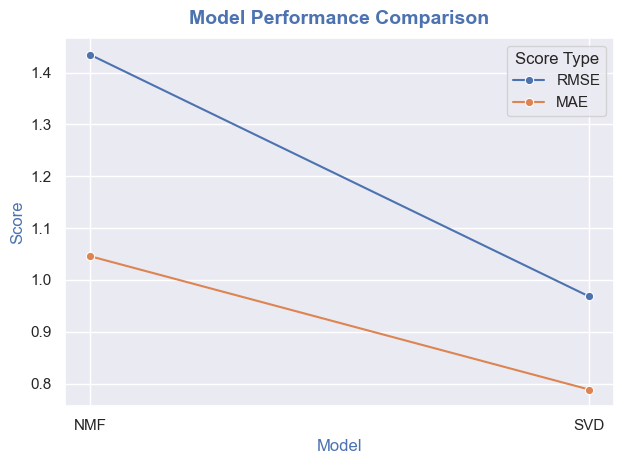

## <span style="color:steelblue"> Content-Based Filtering Model</span>

<em><span style="color:lightsteelblue">Prepare content-based data</span></em>

In [108]:
# goodbooks_cb = goodbooks[['user_id', 'work_id', 'title', 'scaled_embeddings']]

In [109]:
# embeddings = np.array(goodbooks_cb['scaled_embeddings'].tolist()).astype(np.float32)

<em><span style="color:lightsteelblue">Create HNSW (Heirarchical Navigable Small Worlds) index</span></em>

In [110]:
# dim = embeddings.shape[1]
# num_entries = embeddings.shape[0]

In [111]:
# hnsw_index = hnswlib.Index(space='cosine', dim=dim)
# hnsw_index.init_index(max_elements=num_entries, ef_construction=300, M=30)

<em><span style="color:lightsteelblue">Add entries to HNSW index</span></em>

In [112]:
# hnsw_index.add_items(embeddings, ids=np.arange(num_entries))

In [113]:
# hnsw_index.set_ef(300)

<em><span style="color:lightsteelblue">Generate predictions (Example)</span></em>

In [114]:
# work_id = 466
# k=10000
# book_index = goodbooks_cb.index[goodbooks_cb['work_id'] == work_id].tolist()[0]
# query_embedding = embeddings[book_index].reshape(1, -1)
# labels, distances = hnsw_index.knn_query(query_embedding, k=k)

In [115]:
# print(labels)

In [116]:
# predictions = goodbooks_cb.iloc[labels[0]]
# predictions = predictions[predictions['work_id'] != work_id]
# predictions = predictions.drop_duplicates(subset='work_id')[['work_id', 'title']][:10]

In [117]:
# print(predictions)

## <span style="color:steelblue"> Hybrid Recommendation System</span>

<em><span style="color:lightsteelblue">CF Recommendation Function</span></em>

In [118]:
def fetch_cf_data():
    conn = sqlite3.connect('bookscout.db')
    ratings_df = pd.read_sql_query('SELECT * FROM ratings', conn)
    conn.close()
    
    return ratings_df

In [119]:
def prepare_cf_data(ratings_df):
    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(ratings_df[['user_id', 'work_id', 'rating']], reader)
    
    return data

In [120]:
def load_svd():
    try:
        with open('svd.pkl', 'rb') as f:
            return pickle.load(f)
    except FileNotFoundError:
        return None

In [121]:
def train_svd(data):
    svd = load_svd()
    if svd:
        return svd
    
    trainset, testset = train_test_split(data, test_size=0.25)
    svd = SVD(n_factors=150, n_epochs=40, lr_all=0.011, reg_all=0.006)
    svd.fit(trainset)
    
    with open('svd.pkl', 'wb') as f:
        pickle.dump(svd, f)

    return svd

In [122]:
def get_cf_recommendations(user_id):
    ratings_df = fetch_cf_data()
    data = prepare_cf_data(ratings_df)
    model = train_svd(data)
    
    all_books = ratings_df['work_id'].unique()
    rated_books = ratings_df[(ratings_df['user_id'] == user_id) & (ratings_df['rating'] > 0)]['work_id']
    predictions = []
    
    for book in all_books:
        if book not in rated_books:
            pred = model.predict(user_id, book)
            predictions.append((book, pred.est))
    
    predictions.sort(key=lambda x: x[1], reverse=True)
    top_cf_recommendations = predictions[:5]
    return top_cf_recommendations

<em><span style="color:lightsteelblue">CB Recommendation Function</span></em>

In [123]:
def fetch_cb_data():
    conn = sqlite3.connect('bookscout.db')
    books_df = pd.read_sql_query('SELECT work_id, title, embeddings FROM books', conn)
    conn.close()
    
    return books_df

In [124]:
def load_embeddings(books_df):
    # Convert the embeddings from bytes back to numpy arrays
    embeddings = []
    
    for embedding_bytes in books_df['embeddings']:
        if embedding_bytes is not None:
            emb = np.frombuffer(embedding_bytes, dtype=np.float32)
            embeddings.append(emb)
        else:
            embeddings.append(None)
    
    embeddings = [emb for emb in embeddings if emb is not None]
    
    if not embeddings:
        raise ValueError("No valid embeddings found.")
    
    first_embedding_shape = embeddings[0].shape
    for emb in embeddings:
        if emb.shape != first_embedding_shape:
            raise ValueError("Inconsistent embedding shapes found.")   
        
    embeddings_float = np.array(embeddings, dtype=np.float32)
    embeddings_object = np.array([np.frombuffer(embedding_bytes, dtype=np.float32) 
                                  if embedding_bytes else None for embedding_bytes 
                                  in books_df['embeddings']], dtype='object')    
            
    return embeddings_float, embeddings_object

In [125]:
def get_cb_recommendations(work_id, k=10):
    books_df = fetch_cb_data()
    embeddings_float, embeddings_object = load_embeddings(books_df)
    
    if embeddings_float.size == 0:
        raise ValueError("No valid embeddings found.")
    
    dim = embeddings_float.shape[1]
    num_entries = embeddings_float.shape[0]
    hnsw_index = hnswlib.Index(space='cosine', dim=dim)
    hnsw_index.init_index(max_elements=num_entries, ef_construction=300, M=32)
    hnsw_index.add_items(embeddings_float, ids=np.arange(num_entries))
    hnsw_index.set_ef(300)

    book_index = books_df[books_df['work_id'] == work_id].index

    if book_index.size == 0:
        raise ValueError("No valid book index found.")

    # Use book_index[0] to get the scalar index
    query_embedding = embeddings_object[book_index[0]].reshape(1, -1)

    labels, distances = hnsw_index.knn_query(query_embedding, k=k)

    # Check for valid labels
    valid_labels = [label for label in labels[0] if label < len(books_df)]
    
    if not valid_labels:
        print("No valid recommendations found.")
        return []

    top_cb_recommendations = books_df.iloc[valid_labels][['work_id', 'title']]
    top_cb_recommendations = top_cb_recommendations[top_cb_recommendations['work_id'] != work_id]
    top_cb_recommendations = top_cb_recommendations.drop_duplicates(subset='work_id')[['work_id', 'title']][:5]

    return top_cb_recommendations

<em><span style="color:lightsteelblue">Hybrid Recommendation Function</span></em>

In [126]:
def get_hy_recommendations(user_id, work_id, cf_weight=0.5, cb_weight=0.5):
    cf_recommendations = get_cf_recommendations(user_id)
    cf_df = pd.DataFrame(cf_recommendations, columns=['work_id', 'predicted_rating'])
    
    cb_recommendations = get_cb_recommendations(work_id)
    cb_df = cb_recommendations.copy()
    cb_df['predicted_rating'] = 1.0
    
    hy_recommendations = pd.concat([cf_df.rename(columns={'predicted_rating': 'cf_rating'}),
                                 cb_df.rename(columns={'predicted_rating': 'cb_rating'})],
                                 ignore_index=True)
    hy_recommendations = hy_recommendations.groupby('work_id').agg({'cf_rating': 'sum', 'cb_rating': 'sum'}).reset_index()
    hy_recommendations['final_rating'] = (hy_recommendations['cf_rating'] * cf_weight) + (hy_recommendations['cb_rating'] * cb_weight)
    
    top_hy_recommendations = hy_recommendations.sort_values(by='final_rating', ascending=False).head(5)
    books_df = fetch_cb_data()
    final_recommendations = top_hy_recommendations.merge(books_df[['work_id', 'title']], on='work_id', how='left')
    
    return final_recommendations[['work_id', 'title']]

<em><span style="color:lightsteelblue">Generate recommendations (Example)</span></em>

In [127]:
# reset_database()
# setup_database()
# insert_books_from_df(goodbooks)
# insert_ratings_from_df(goodbooks)

In [128]:
user_id = 1
work_id = 466

recommendations = get_hy_recommendations(user_id, work_id)
print(recommendations)

   work_id                                              title
0     5397  Freakonomics: A Rogue Economist Explores the H...
1  2792775                                   The Hunger Games
2   463407                                      My Man Jeeves
3   463790                                  Dark Force Rising
4   464034                                             Maktub
